# Circular variables

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns
import math

import latenta as la
la.logger.setLevel("INFO")

## Transformation of a circular variable

A circular variable is defined as a variable that "wraps around". To model this in an unconstrained space, we can convert this variable to two orthogonal cartesian coordinates.

In [2]:
n_samples = 150
sample_ids = [str(i) for i in range(n_samples)]
sample_index = pd.Series(sample_ids, name = "cell")

angle_value = pd.Series(np.linspace(0., (2. * np.pi), n_samples) % (2 * math.pi), index = sample_index)
angle = la.Fixed(angle_value, distribution = la.distributions.CircularUniform(), label = "angle", symbol = r"\theta")
angle

angle:  ↦ Fixed [cell (150)]

In [3]:
cartesian = la.links.scalar.Cartesian(angle, label = "cartesian")
cartesian

cartesian: x ↦ Cartesian [cell (•), axis (2)] = $\left[ cos(\theta)\;\;sin(\theta) \right]\require{action}$

In [4]:
angle2 = la.links.vector.Circular(cartesian, label = "the same angle", symbol = r"\theta 2")
angle2

the same angle: x ↦ Circular [cell (•)] = $\text{atan2}(x)\require{action}$


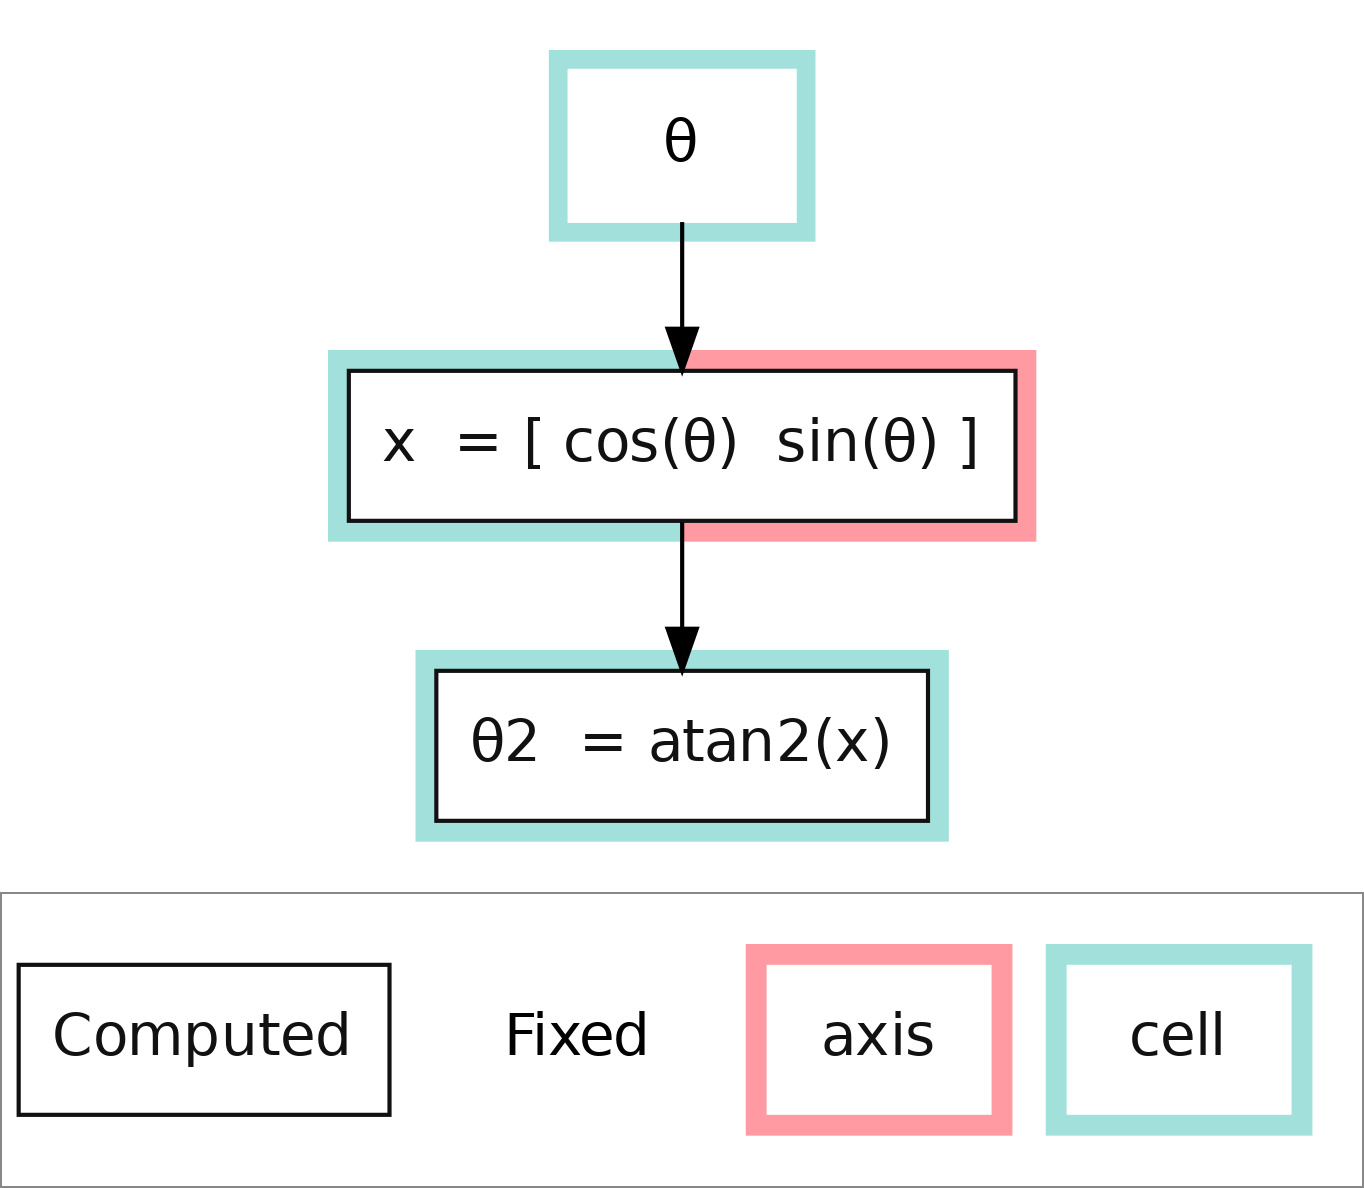

In [5]:
angle2.plot()

In [6]:
assert torch.allclose(angle.prior(), angle2.prior())

## Transforming a normal distribution to sample circular values

In [7]:
coordinates = la.Fixed(
    pd.DataFrame(
        [[1., 0.], [2., 0.], [0., 1.],[-1., 0.], [0., -1.]],
        index = pd.Series([0, "0bis", 90, 180, 270], name = "angles"),
        columns = pd.Series(["x", "y"], name = "axis")
    )
)
dist1_untransformed = la.distributions.Normal(coordinates, scale = 0.5)
dist1 = la.links.vector.Circular(dist1_untransformed)

  0%|          | 0/200 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Frequency'>

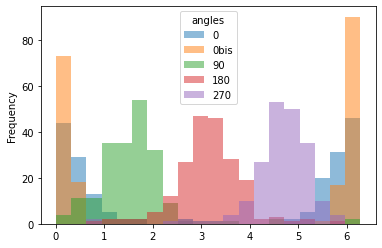

In [8]:
posterior = la.posterior.Posterior(dist1)
posterior.sample(200)

posterior.samples[dist1].to_pandas().plot(kind = "hist", bins = 20, alpha = 0.5)

Correction of the likelihood
In this case, because the transformation is not bijective, the inverse likelihoods are not corrected.

In [9]:
dist1.reset_recursive()
dist1.run_recursive()
dist1.x.value = coordinates.prior()
uncorrected_likelihood = dist1.x.likelihood.sum(-1)
corrected_likelihood = dist1.likelihood

print(corrected_likelihood - uncorrected_likelihood)

tensor([ 0.0000, -0.6931,  0.0000,  0.0000,  0.0000])


Alternative, assigning the transformation directly to the variable

In [10]:
dist2 = la.distributions.Normal(coordinates, scale = 0.5, transforms = [la.transforms.Circular()])

## Generative model

In [11]:
n_genes = 100
gene_ids = [str(i) for i in range(n_genes)]
genes = la.Dim(pd.Series(gene_ids, name = "gene"))

beta = la.Fixed(pd.Series(np.random.uniform(-3, 3, n_genes), index = genes.index), label = "beta")
shift = la.Fixed(pd.Series(np.random.uniform(0., 2 * np.pi, n_genes), index = genes.index), label = "shift")
scale = la.Fixed(pd.Series(np.random.uniform(0.2, 2., n_genes), index = genes.index), label = "scale")

In [12]:
y = la.links.scalar.Sine(x = angle, a = beta, shift = shift)

In [13]:
dist = la.distributions.Normal(loc = y, scale = scale)


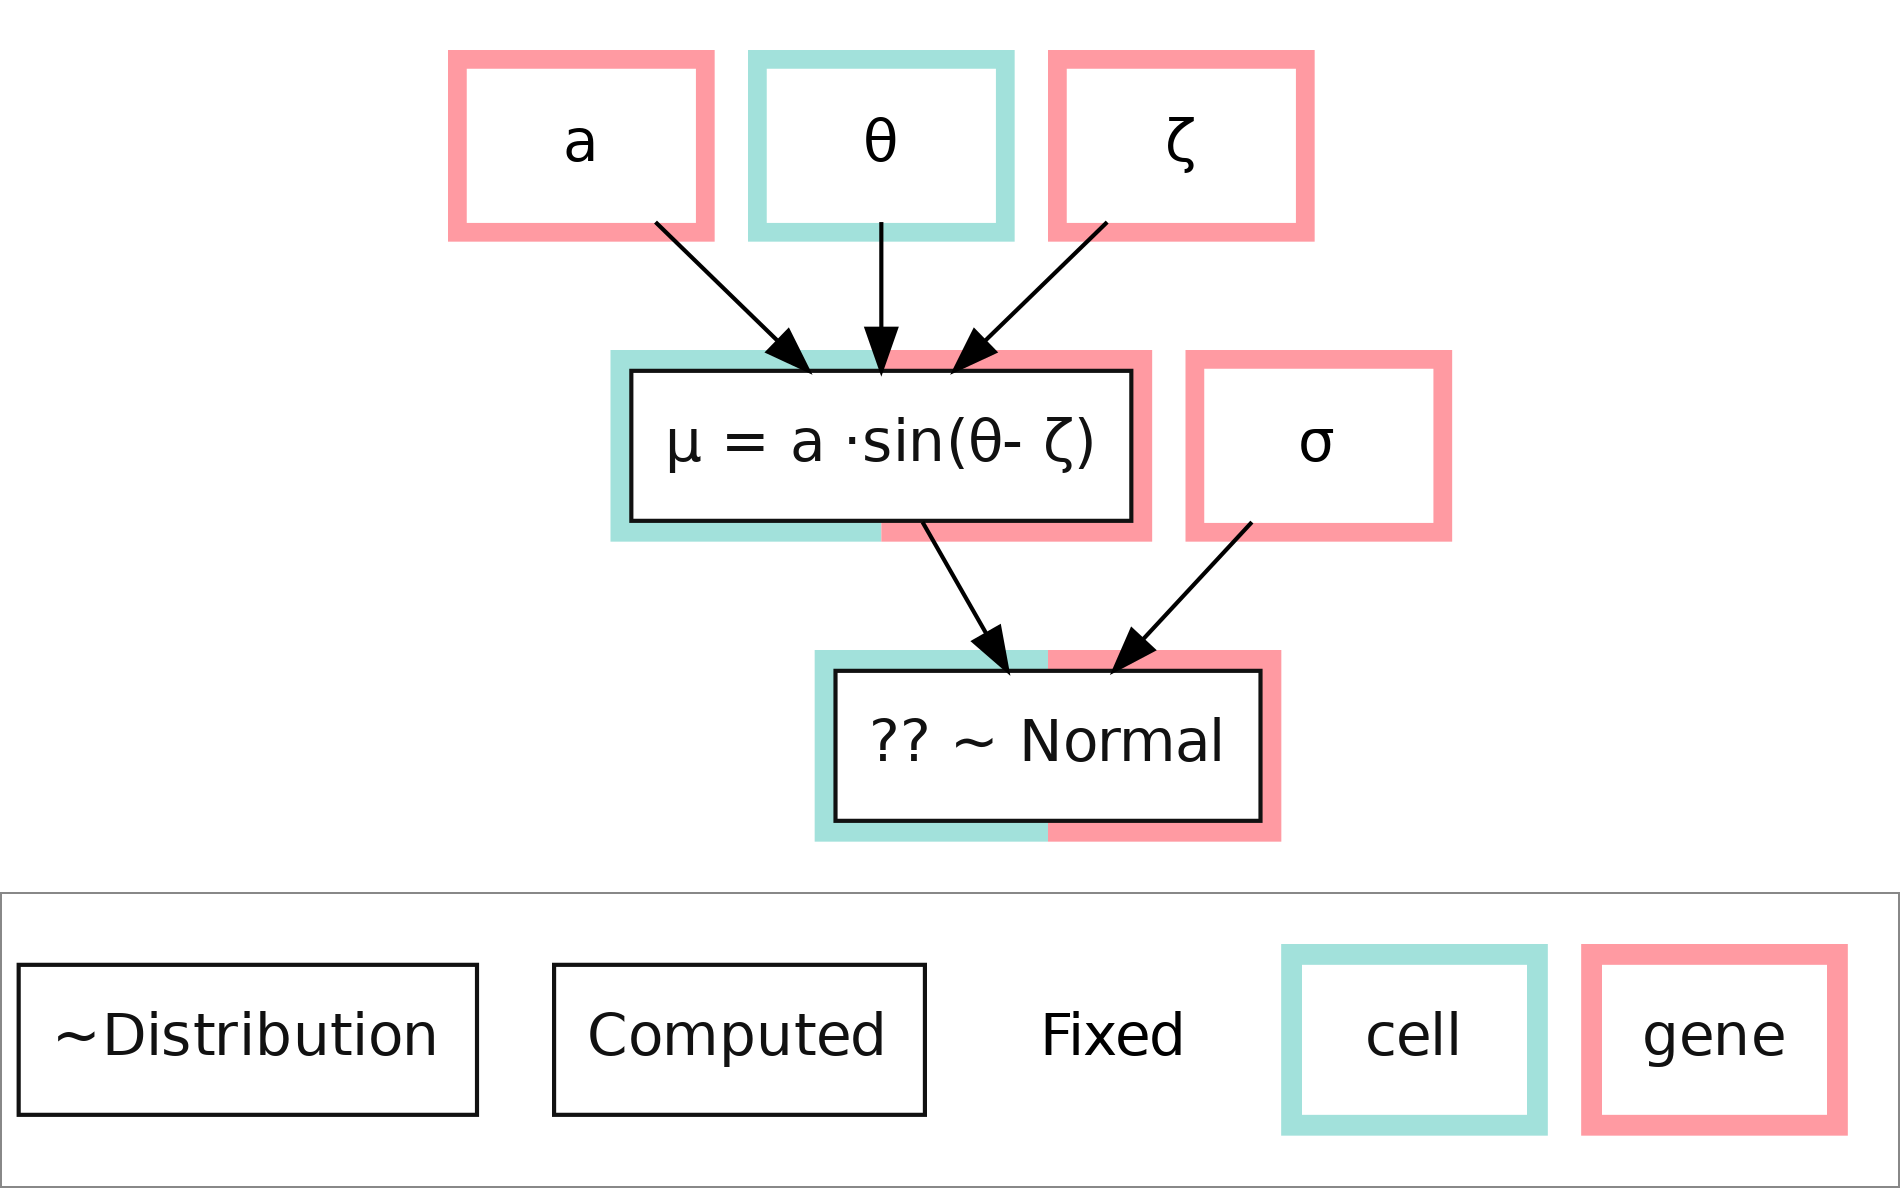

In [14]:
dist.plot()

<AxesSubplot:>

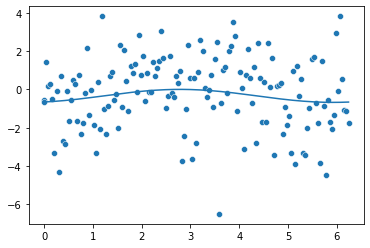

In [15]:
sns.lineplot(x = angle.prior().numpy(), y = y.prior()[:, 0].numpy())
sns.scatterplot(x = angle.prior().numpy(), y = dist.prior()[:, 0].numpy())

In [16]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

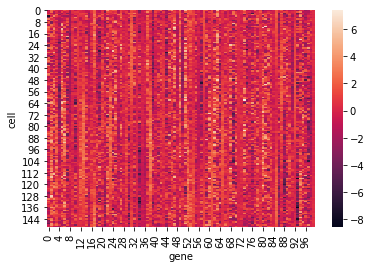

In [17]:
observation_value = posterior.samples[dist].sel(sample = 0).to_pandas()
sns.heatmap(observation_value)

## Bayesian modelling

In [18]:
x = la.Latent(
    la.distributions.CircularUniform(),
    definition = angle
)


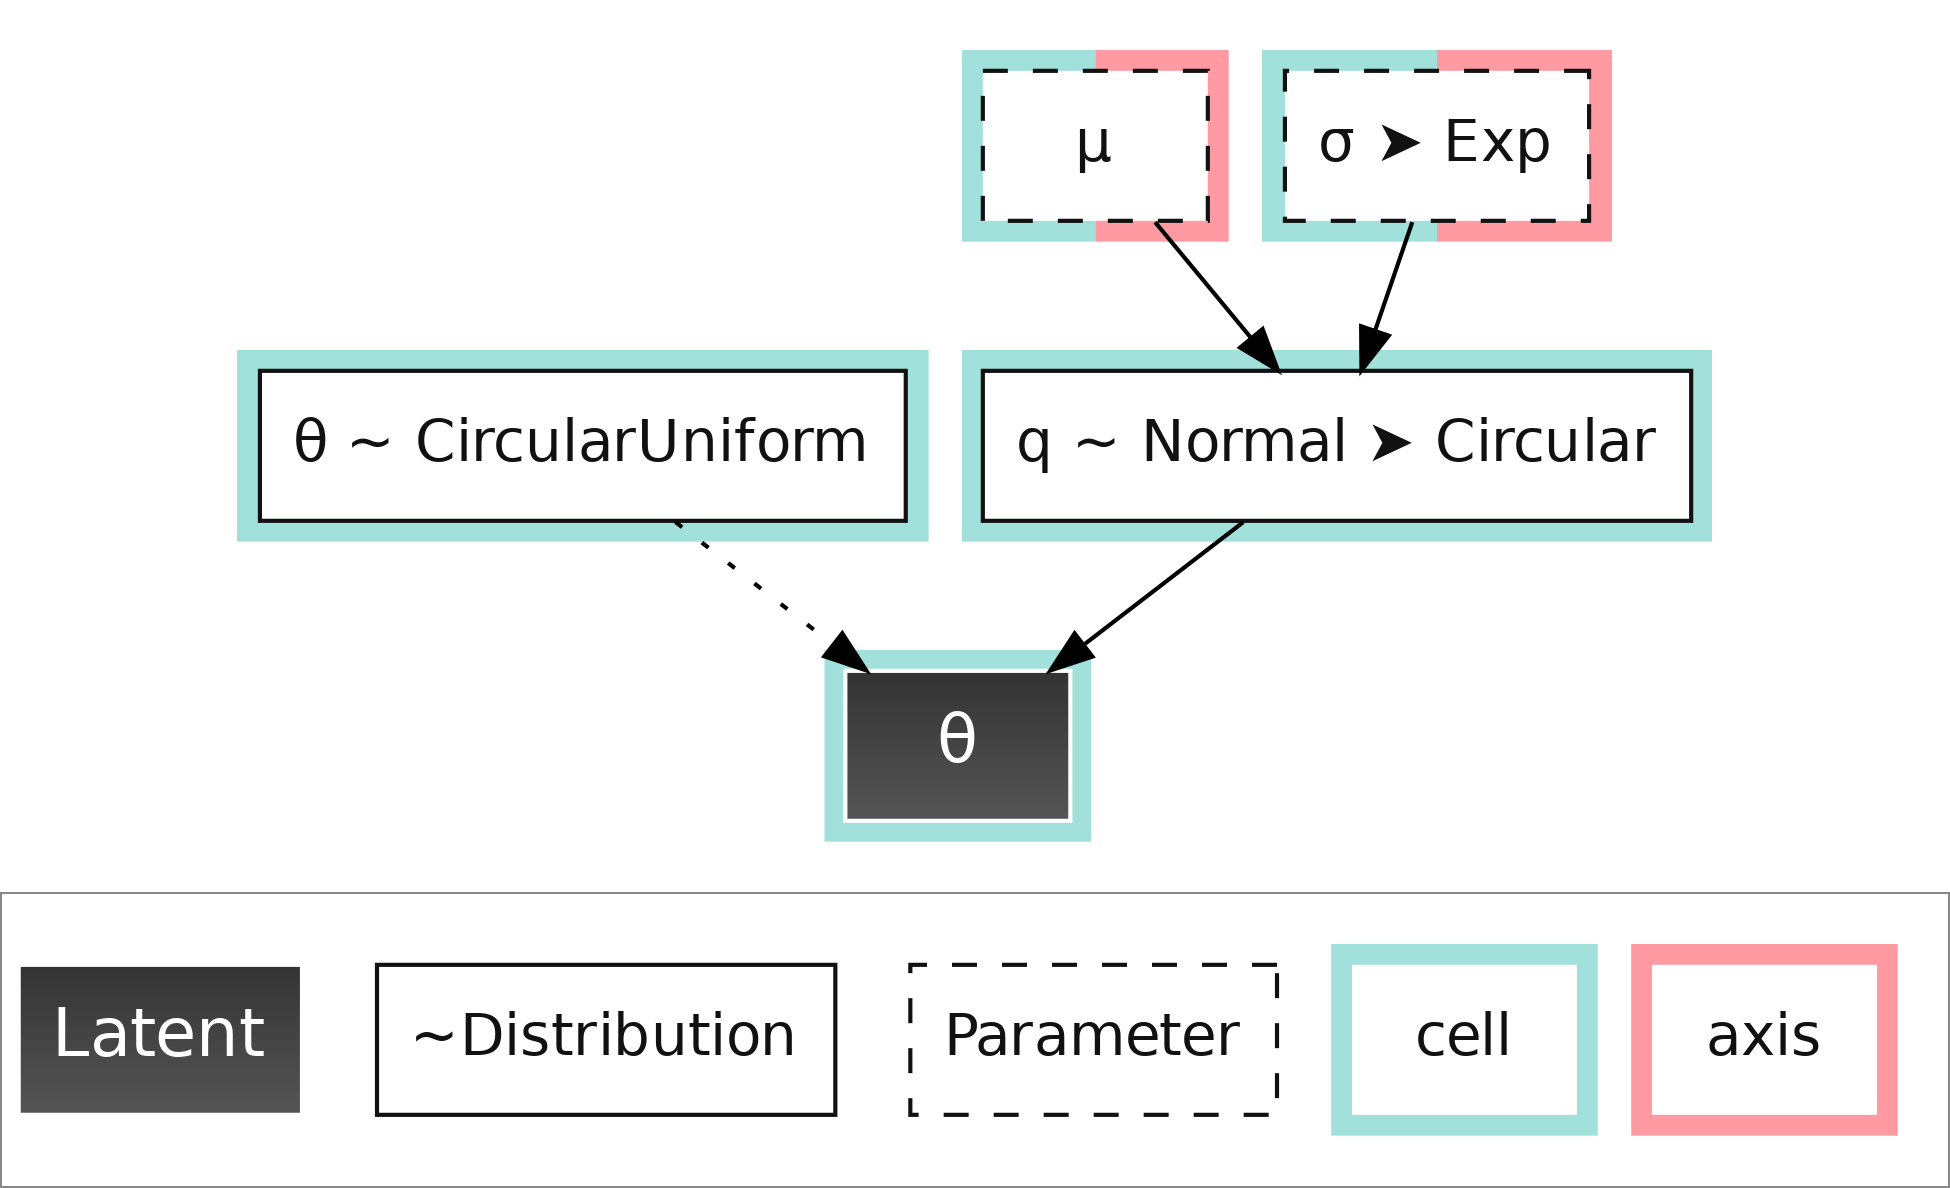

In [19]:
x.plot()

In [20]:
output_definition = la.Definition.from_xr(observation_value)
output_definition

??: Definition [cell (150), gene (100)]

In [21]:
s_dist = la.distributions.LogNormal(1., 0.5)
s = la.Latent(s_dist, definition = la.Definition(), label = "scale")

In [22]:
z = la.links.scalar.Sine(
    x, 
    a = la.Latent(la.distributions.Normal(), definition = beta),
    shift = la.Latent(la.distributions.CircularUniform(), definition = shift),
    output = output_definition,
    b = True
)

In [25]:
z = la.links.scalar.CircularSpline(
    x, 
    output = output_definition,
    b = True
)

In [26]:
z.empirical = xr.DataArray(observation_value)

In [27]:
dist2 = la.distributions.Normal(loc = z, scale = s)

observation = la.Observation(observation_value, dist2, label = "observation")


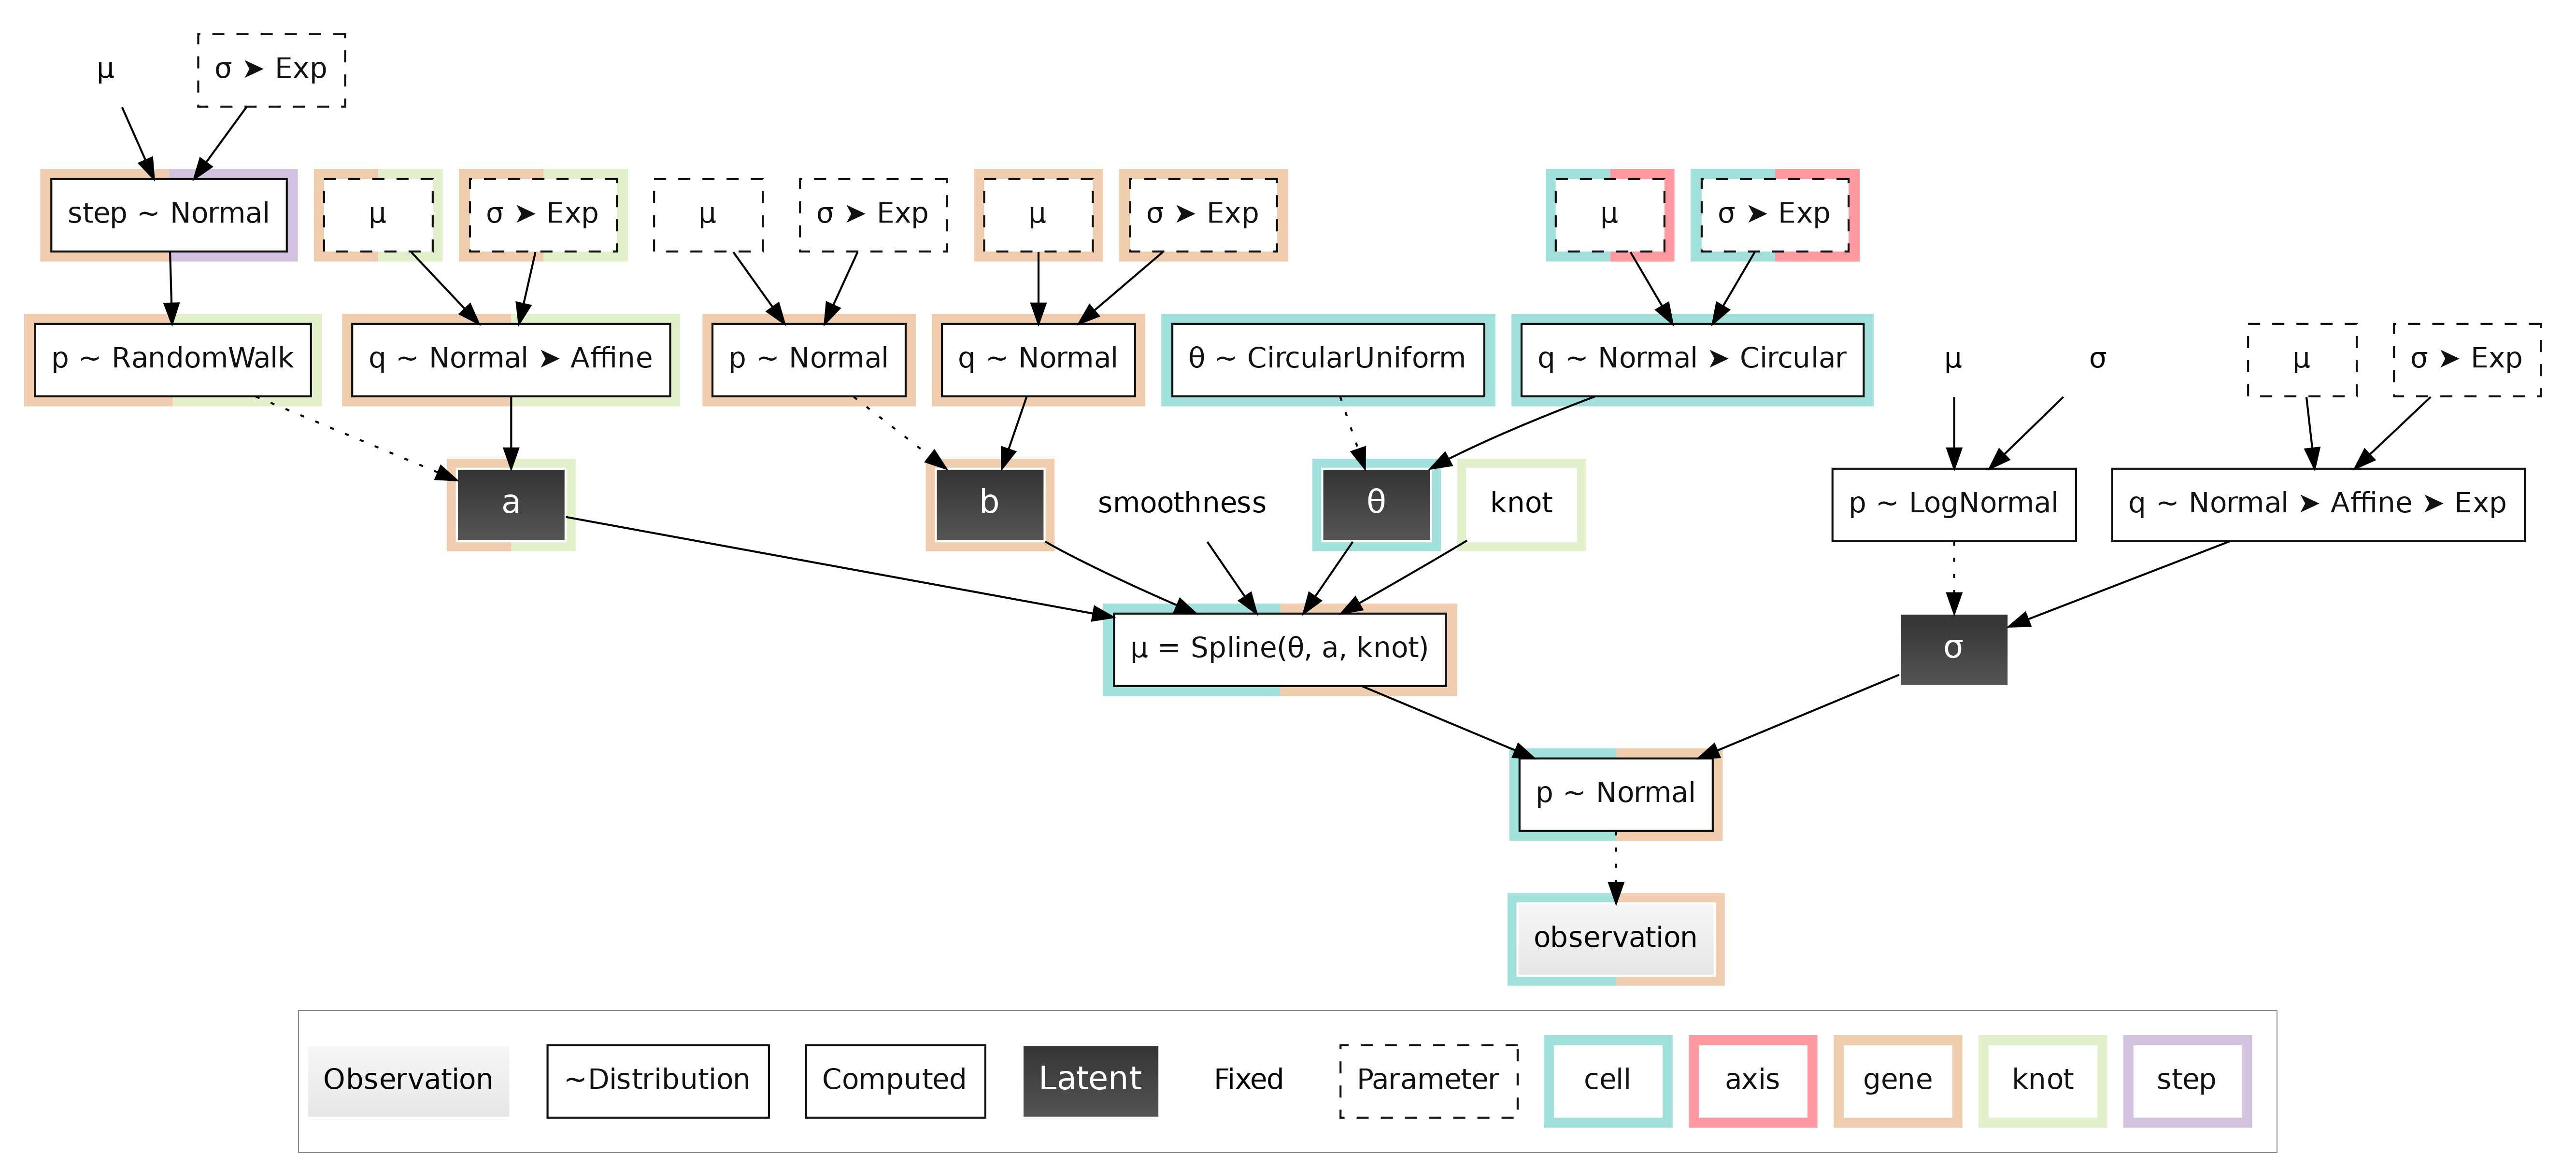

In [28]:
observation.plot()

In [29]:
model = la.Model(observation)

In [30]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01), subsamplers = {"cell":la.infer.subsampling.Subsampler(50)})
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)

  0%|                                                                                                         …

In [31]:
observed = la.posterior.Observed(observation)
observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

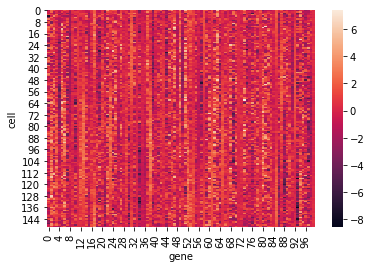

In [32]:
sns.heatmap(observation_value)

<AxesSubplot:xlabel='gene', ylabel='cell'>

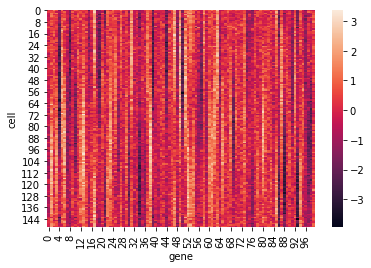

In [33]:
modelled_value = observed.samples[observation.p].mean("sample").to_pandas()
sns.heatmap(modelled_value)

<AxesSubplot:>

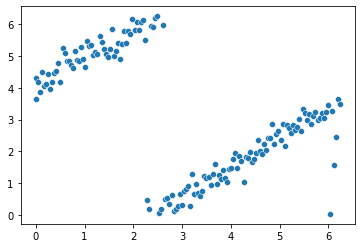

In [35]:
sns.scatterplot(
    x = angle.prior_pd(),
    y = la.domains.circular.mean(observed.samples[x], "sample").to_pandas()
)

<AxesSubplot:>

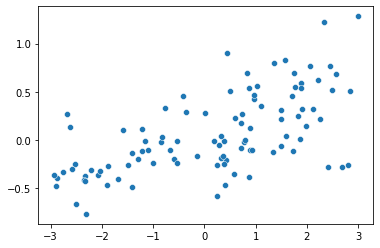

In [36]:
sns.scatterplot(
    x = beta.prior_pd(),
    y = observed.samples[z.b].mean("sample").to_pandas()
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

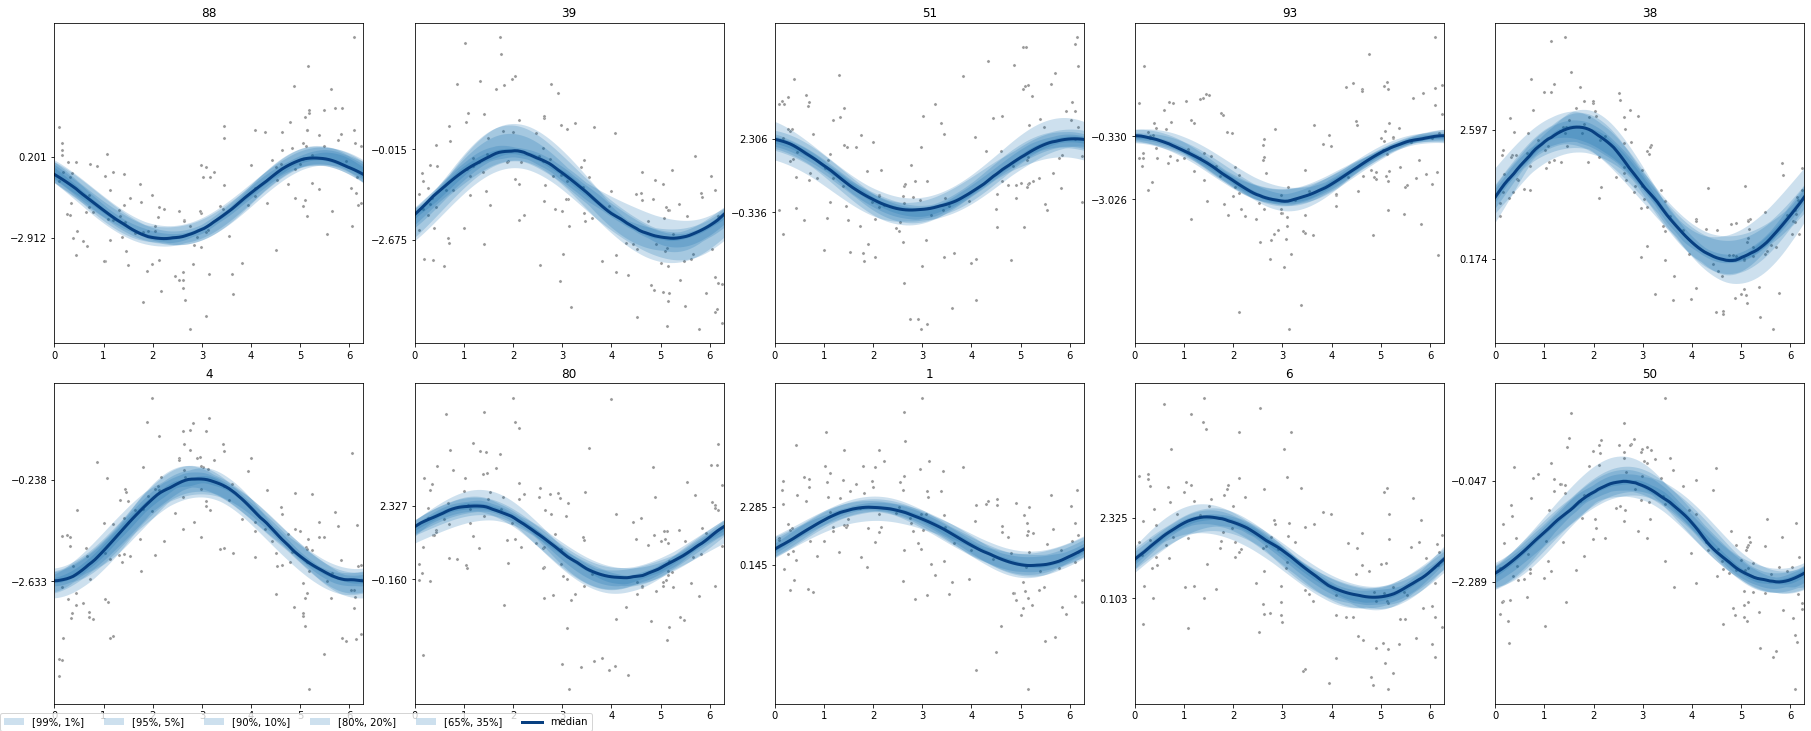

In [40]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(20)
causal.sample_bootstrap(10)
causal.plot_features();

## Amortization

In [43]:
encoder = la.amortization.Encoder(
    la.Fixed(observation_value, label = "observed"),
    x
)


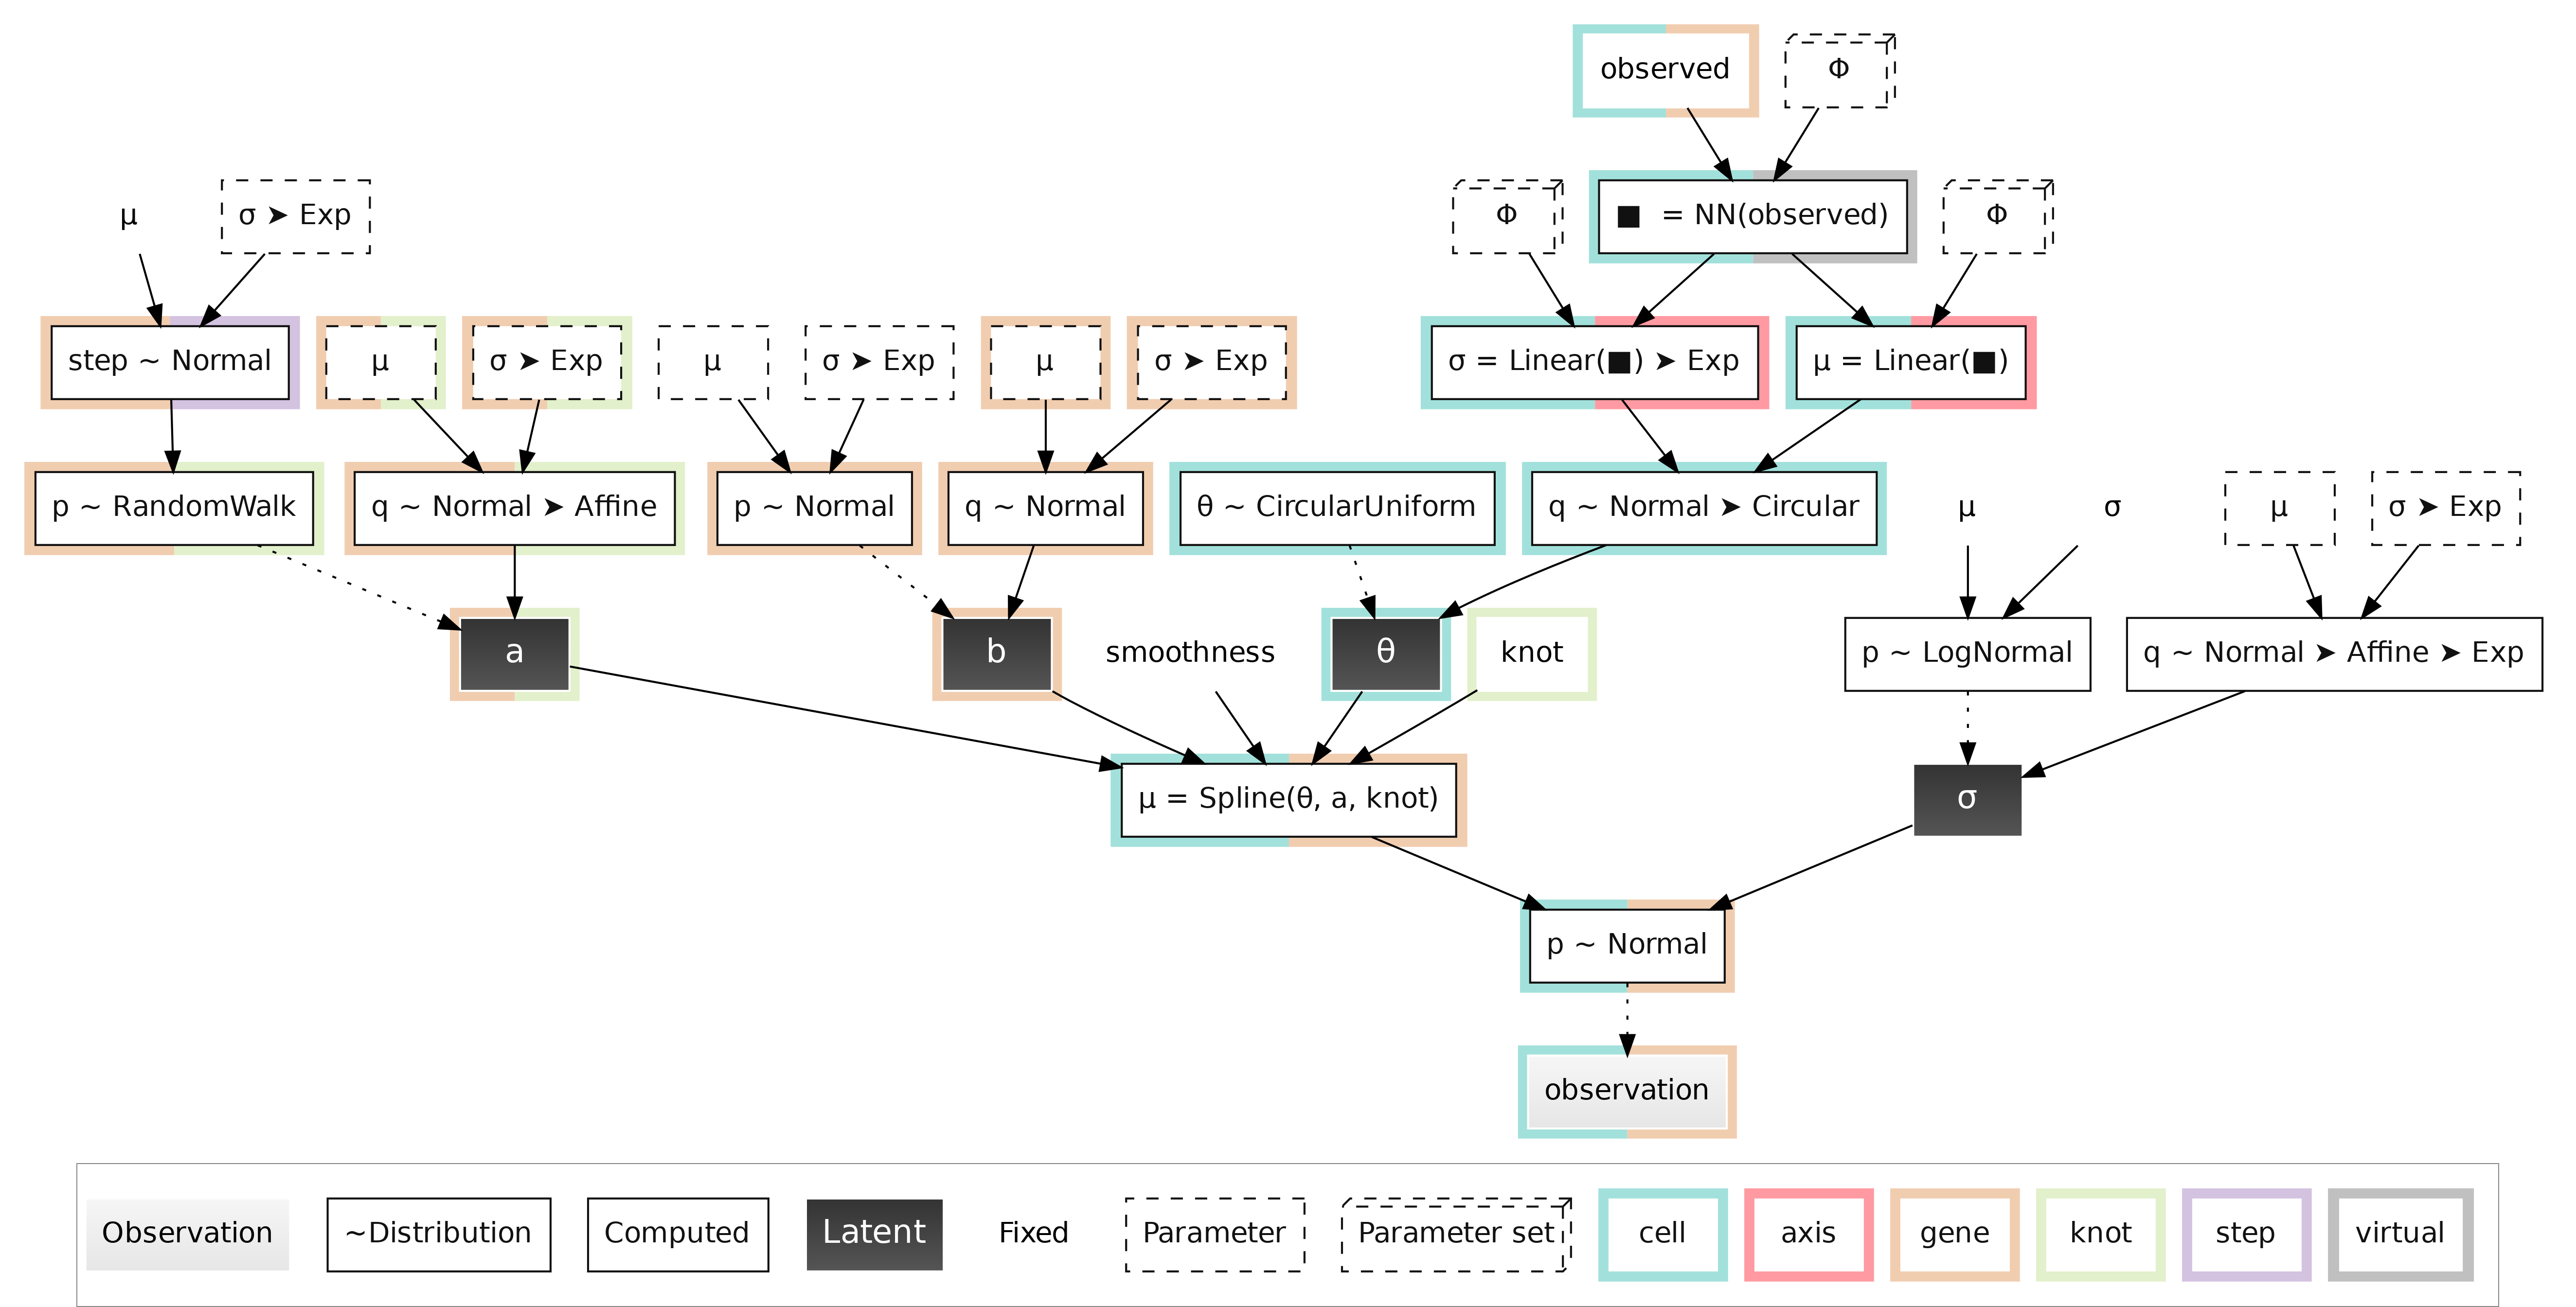

In [44]:
observation.plot()

In [45]:
model = la.Model(observation)

In [46]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.01))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [47]:
posterior = la.posterior.Posterior(observation)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

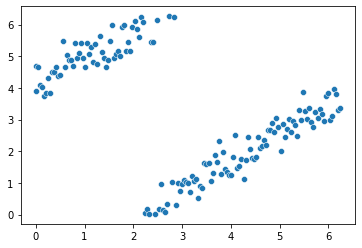

In [48]:
sns.scatterplot(
    x = angle.prior_pd(),
    y = posterior.samples[x].mean("sample").to_pandas()
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

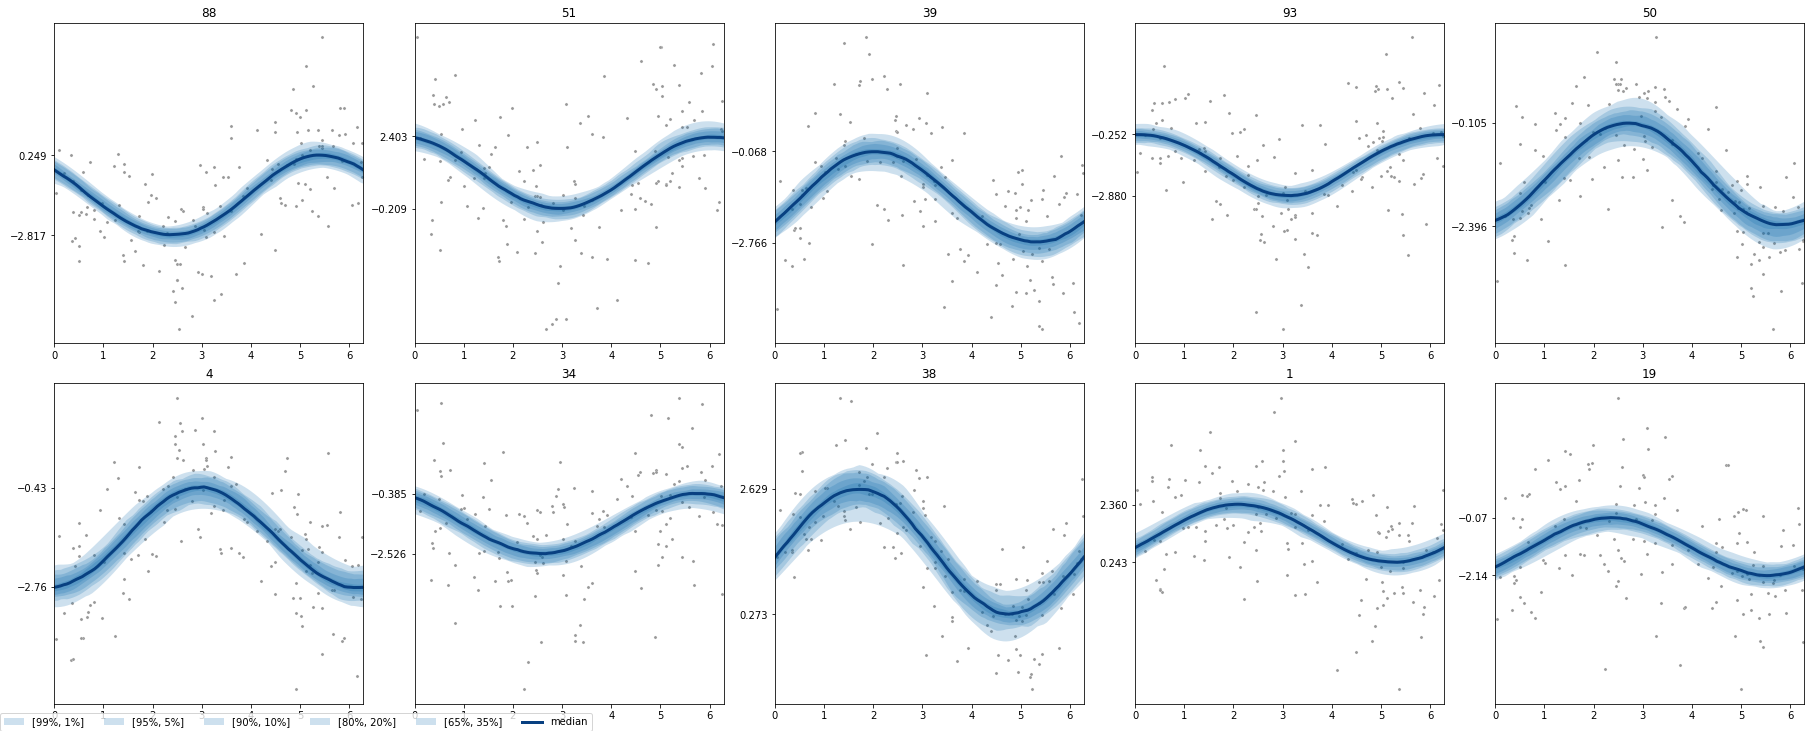

In [49]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(100)
causal.sample_bootstrap(10)
causal.plot_features(interpretable = observation.p.loc);